In [1]:
# https://pypi.org/project/audioread/

import librosa
import librosa.display
import soundfile as sf
#import ffmpy
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
from pydub import AudioSegment

In [2]:
def load_file(filename):
    return librosa.load(glob(filename)[0])

y, sr = load_file("../test.mp3")

In [3]:
def calculate_rms(samples):
    """Given a numpy array of audio samples, return its Root Mean Square (RMS)."""
    return np.sqrt(np.mean(np.square(samples)))

def calculate_desired_noise_rms(clean_rms, snr):
    """
    Given the Root Mean Square (RMS) of a clean sound and a desired signal-to-noise ratio (SNR),
    calculate the desired RMS of a noise sound to be mixed in.
    Based on https://github.com/Sato-Kunihiko/audio-SNR/blob/8d2c933b6c0afe6f1203251f4877e7a1068a6130/create_mixed_audio_file.py#L20
    :param clean_rms: Root Mean Square (RMS) - a value between 0.0 and 1.0
    :param snr: Signal-to-Noise (SNR) Ratio in dB - typically somewhere between -20 and 60
    :return:
    """
    a = float(snr) / 20
    noise_rms = clean_rms / (10**a)
    return noise_rms



In [4]:
def convert_decibels_to_amplitude_ratio(decibels):
    return 10 ** (decibels / 20)

def set_noise(y, noise_rms):
    #amp = convert_decibels_to_amplitude_ratio(decibels)
    #y = np.random.rand(y.shape[0])*amp*2-amp
    noise = np.random.normal(
            0.0, noise_rms, size=y.shape
        )
    return noise

print(y.shape)
y = np.delete(y, np.s_[40000:45000])
print(y.shape)

y[20000:40000] = 0
rms=calculate_rms(y)
noise_rms=calculate_desired_noise_rms(rms,30)
y[20000:40000] = set_noise(y[20000:40000], noise_rms)

(72277,)
(67277,)


<Axes: >

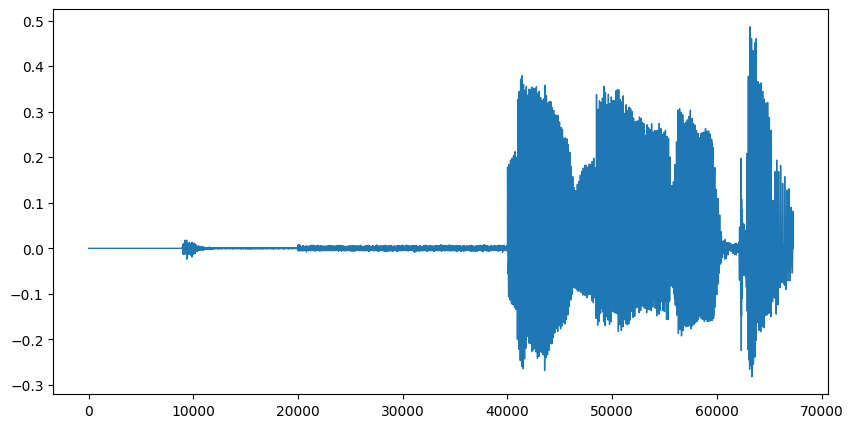

In [5]:
pd.Series(y).plot(figsize=(10, 5), lw=1, title="")

In [6]:
sf.write('out.wav', y, sr, 'PCM_24')
os.system("rm out.mp3")
os.system("ffmpeg -i out.wav out.mp3")
os.system("rm out.wav")

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

0

In [7]:
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

<Figure size 640x480 with 0 Axes>

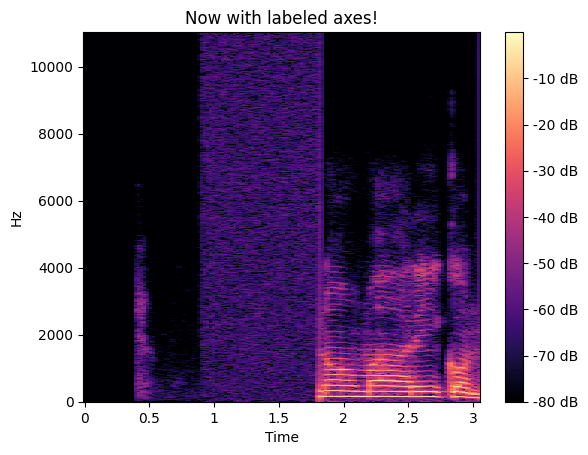

In [8]:
plt.figure()
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Now with labeled axes!')
fig.colorbar(img, ax=ax, format="%+2.f dB")



ffmpeg -i input.wav -codec:a libmp3lame -qscale:a 2 output.mp3

Control quality with -qscale:a (or the alias -q:a). Values are encoder specific, so for libmp3lame the range is 0-9 where a lower value is a higher quality. 0-3 will normally produce transparent results, 4 (default) should be close to perceptual transparency, and 6 produces an "acceptable" quality. The option -qscale:a is mapped to the -V option in the standalone lame command-line interface tool.

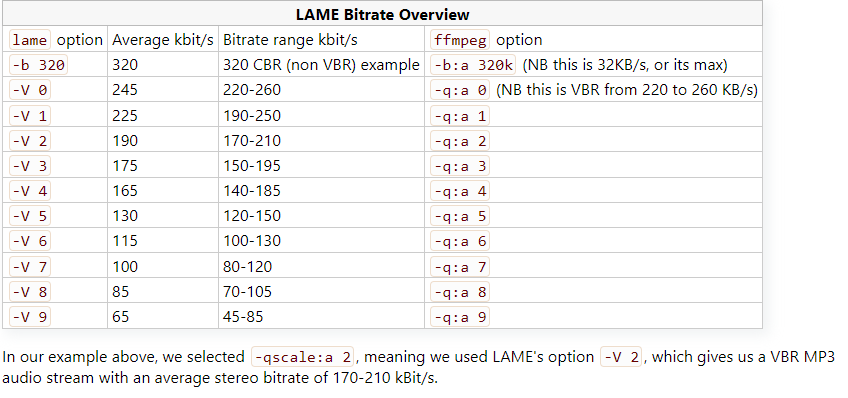

In [10]:
#test mp3compression
#0->best
#4->perceptual transparency
#6->acceptable
#8->bad
def mp3compression(inputfile,outputfile,quality=4):
    os.system("ffmpeg -i " + inputfile +" -codec:a libmp3lame -q:a " + str(quality) + " " +outputfile)

mp3compression("out.mp3","pito.mp3",6)


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

0

In [ ]:
#clipping

def clipping(samples,percentile_threshold=20):
    lower_percentile_threshold = percentile_threshold/2
    lower_threshold, upper_threshold = np.percentile(
            samples, [lower_percentile_threshold, 100 - lower_percentile_threshold])
    samples = np.clip(samples, lower_threshold, upper_threshold)
    return samples